/tmp/ipykernel_28497/3803841577.py:53: DeprecationWarning: DEPRECATED: replace `path.to_planar`->`path.to_2D), removal 1/1/2026
  planar, T = sec.to_planar()


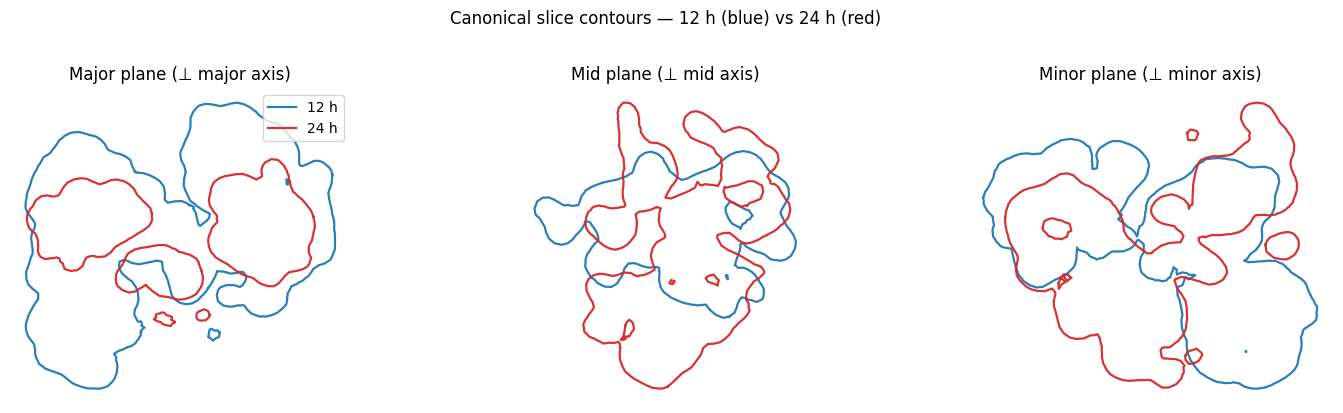

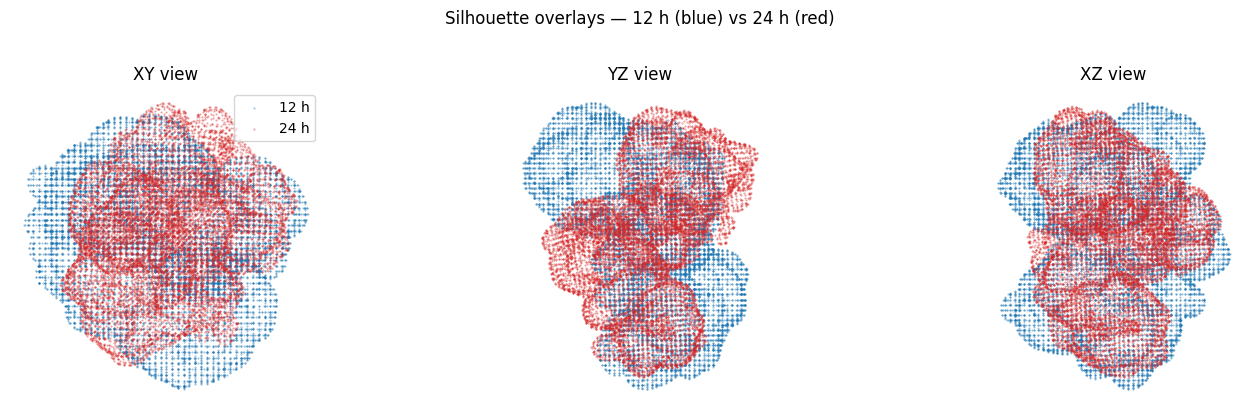

=== Metrics (12 h) ===
volume                  : -248.61060456036276
surface_area            : 383.00782338763446
sphericity              : nan
axis_lengths_(maj,mid,min): (12.056226372511365, 9.050826172037077, 7.150777668556607)
anisotropy_(maj/min)    : 1.686002128904803

=== Metrics (24 h) ===
volume                  : -158.78634725436257
surface_area            : 316.76489396404787
sphericity              : nan
axis_lengths_(maj,mid,min): (10.611690203944509, 7.83634196545648, 7.52251418677487)
anisotropy_(maj/min)    : 1.4106573866754064

=== Δ% (24 h vs 12 h) ===
volume                  : -36.13%
surface_area            : -17.30%
sphericity              : nan%
anisotropy_(maj/min)    : -16.33%


In [1]:
# === A/B Slices + Silhouettes + Metrics (drop-in cell) ===================
import numpy as np, trimesh
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

# ---------------------- set your two meshes here -------------------------
meshA_path = "data/green_monkey/all_structure_files/chr1/spatial_data/overall_shapes/chr1_12hrs_vacv_metaball.obj"
meshB_path = "data/green_monkey/all_structure_files/chr1/spatial_data/overall_shapes/chr1_24hrs_vacv_metaball.obj"  # <- update if needed

# ---------------------- small helpers ------------------------------------
def center_vertices(m):
    v = m.vertices - m.vertices.mean(axis=0)
    return trimesh.Trimesh(vertices=v, faces=m.faces, process=False)

def kabsch(P, Q):
    """Rigid fit Q->P (same #points). Returns R(3x3), t(3,)."""
    Pc = P.mean(0); Qc = Q.mean(0)
    P0 = P - Pc; Q0 = Q - Qc
    H = Q0.T @ P0
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1,:] *= -1
        R = Vt.T @ U.T
    t = Pc - Qc @ R.T
    return R, t

def icp_rigid(A_pts, B_pts, iters=10, sample=5000):
    """Align B->A using nearest-neighbor ICP."""
    A = A_pts if len(A_pts) <= sample else A_pts[np.random.choice(len(A_pts), sample, replace=False)]
    B = B_pts if len(B_pts) <= sample else B_pts[np.random.choice(len(B_pts), sample, replace=False)]
    R = np.eye(3); t = np.zeros(3)
    for _ in range(iters):
        Bx = B @ R.T + t
        tree = cKDTree(A)
        d, idx = tree.query(Bx, k=1)
        P = A[idx]
        R_upd, t_upd = kabsch(P, Bx)
        R = R_upd @ R
        t = (t @ R_upd.T) + t_upd
    return R, t

def pca_axes(verts):
    C = np.cov(verts.T)
    w, V = np.linalg.eigh(C)  # ascending
    order = np.argsort(w)[::-1]
    return V[:, order]  # columns: major, mid, minor

def section_paths_2d(mesh, origin, normal):
    """Slice mesh by plane; return list of 2D polylines in that plane."""
    sec = mesh.section(plane_origin=origin, plane_normal=normal)
    if sec is None: return []
    planar, T = sec.to_planar()
    polys = []
    for ent in planar.entities:
        pts = planar.vertices[ent.points]
        polys.append(pts)
    return polys

def plot_polylist(ax, polys, color, label=None):
    for k, pts in enumerate(polys):
        ax.plot(pts[:,0], pts[:,1], color=color, lw=1.6, alpha=0.95, label=(label if k==0 else None))

def ortho_outline_2d(mesh, axes=(0,1)):
    """Project vertices to 2D plane (axes tuple) and draw outline by alpha hull-like trick."""
    # Quick scatter (outline effect via low alpha + thicker edge)
    uv = mesh.vertices[:, axes]
    return uv

def sphericity(volume, area):
    if volume <= 0 or area <= 0: return np.nan
    return (np.pi**(1/3)) * ((6*volume)**(2/3)) / area

# ---------------------- load + align -------------------------------------
mA = center_vertices(trimesh.load(meshA_path, process=False))
mB_raw = center_vertices(trimesh.load(meshB_path, process=False))

R, t = icp_rigid(mA.vertices, mB_raw.vertices, iters=12, sample=8000)
mB = trimesh.Trimesh(vertices=mB_raw.vertices @ R.T + t, faces=mB_raw.faces, process=False)

# PCA frame from A
axes = pca_axes(mA.vertices)   # columns are unit vectors
ctr = np.zeros(3)              # after centering, origin is 0

# ---------------------- slice overlays -----------------------------------
planes = [
    ("Major plane (⊥ major axis)",  axes[:,2]),  # normal = minor axis -> section shows major/mid
    ("Mid plane (⊥ mid axis)",      axes[:,0]),  # normal = major axis
    ("Minor plane (⊥ minor axis)",  axes[:,1])   # normal = mid axis
]

fig, axs = plt.subplots(1, 3, figsize=(15,4))
for ax, (title, normal) in zip(axs, planes):
    pA = section_paths_2d(mA, ctr, normal)
    pB = section_paths_2d(mB, ctr, normal)
    plot_polylist(ax, pA, color="#1f77b4", label="12 h")
    plot_polylist(ax, pB, color="#d62728", label="24 h")
    ax.set_aspect('equal', 'box'); ax.set_title(title); ax.axis('off')
axs[0].legend(loc="upper right")
plt.suptitle("Canonical slice contours — 12 h (blue) vs 24 h (red)", y=1.02, fontsize=12)
plt.tight_layout(); plt.show()

# ---------------------- silhouette overlays (3 orthographic views) -------
views = [("XY view", (0,1)), ("YZ view", (1,2)), ("XZ view", (0,2))]
fig, axs = plt.subplots(1,3, figsize=(15,4))
for ax, (title, axes2) in zip(axs, views):
    uvA = ortho_outline_2d(mA, axes=axes2)
    uvB = ortho_outline_2d(mB, axes=axes2)
    ax.scatter(uvA[:,0], uvA[:,1], s=0.2, c="#1f77b4", alpha=0.5, label="12 h")
    ax.scatter(uvB[:,0], uvB[:,1], s=0.2, c="#d62728", alpha=0.5, label="24 h")
    ax.set_aspect('equal', 'box'); ax.set_title(title); ax.axis('off')
axs[0].legend(loc="upper right")
plt.suptitle("Silhouette overlays — 12 h (blue) vs 24 h (red)", y=1.02, fontsize=12)
plt.tight_layout(); plt.show()

# ---------------------- quick metrics ------------------------------------
def basic_metrics(m):
    vol = m.volume if m.is_watertight else np.nan
    area = m.area
    # Axis lengths via PCA std devs (×2 for diameter-ish measure)
    A = pca_axes(m.vertices)
    coords_in_pca = (m.vertices - m.vertices.mean(0)) @ A
    extents = coords_in_pca.ptp(0)  # range along each axis
    maj, mid, minr = extents
    return {
        "volume": float(vol),
        "surface_area": float(area),
        "sphericity": float(sphericity(vol, area)) if np.isfinite(vol) else np.nan,
        "axis_lengths_(maj,mid,min)": (float(maj), float(mid), float(minr)),
        "anisotropy_(maj/min)": float(maj / max(minr, 1e-8))
    }

mA_stats = basic_metrics(mA)
mB_stats = basic_metrics(mB)

print("=== Metrics (12 h) ===")
for k,v in mA_stats.items(): print(f"{k:24s}: {v}")
print("\n=== Metrics (24 h) ===")
for k,v in mB_stats.items(): print(f"{k:24s}: {v}")

def pct_change(a, b):
    return (b - a) / a * 100.0 if a and np.isfinite(a) and a != 0 else np.nan

print("\n=== Δ% (24 h vs 12 h) ===")
for key in ["volume", "surface_area", "sphericity", "anisotropy_(maj/min)"]:
    print(f"{key:24s}: {pct_change(mA_stats[key], mB_stats[key]):.2f}%")
